# Gaussian processes

This brief introduction will walk you through the Gaussian process regression implementation. The goal is to provide a conceptual understanding of the Gaussian process.

This type of analytical approach is an incredible tool to model uncertainty and it can also be used for active learning applications.

Gaussian processes is a non-parametric supervised machine learning method that is not sparse, i.e. it works with the complete training data for inferences. This, however, creates some scalability issues as processing can be slower and more demanding computationally.

Gaussian processes are stochastic and describe distributions over functions which make them excellent tools for uncertainty modelling and other probabilistic analyses.

For more technical details please refer to [Gaussian Processes for Machine Learning](http://gaussianprocess.org/gpml/chapters/RW.pdf)

In [5]:
#Import libraries

import numpy as np
import pandas as pd
import scipy
import math
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Gaussian process description

Gaussian processes are distributions over functions $f(x)$ where the distribution of functions is defined by mean $m(x)$ and positive definite covariance function $k(x,x')$. This can be described as the following equations covering the input domain over all pairs of $x$:

$f(x) \sim Gp(m(x),k(x,x'))$

A really important characteristic is that a subset $X=\{ x_1,...x_n\}$ for the domain of $x$ is the marginal distribution which is also Gaussian. The covariance function models joint variability or covariance of the Gaussian process random variable pairs. The mean is typically set to 0 (as many outputs and analyses are normalised); however, if the mean is known to have specific sampling values, it can be changed to that value.

$f(X) \sim \N(m(X),k(X,X'))$ with $\mu(X)$ mean and $\Sigma=k(X,X)$ covariance.

Since the covariance matrix and the mean are defined by functions, in order to sample functions from the Gaussian process it is necessary to define these two functions. The covariance matrix can be found using kernel functions. We will specify a RBF (radial basis function) kernel for the purposes of this tutorial.

$k(x,x')=exp(\frac{-1}{2\sigma^{2}}||x-x'||^{2})$

In [6]:
def kernel(X1,X2,l=1.0,sigma=1.0):

    """
    RBF kernel calculation using observation ||x1-x2||^2=(x1-x2).T*(x1-x2)=
    X1.T*X1+X2.T*X2-2*X1*X2.T

    #Arguments
    X1, array(int/float), nxk values: value array for kernel calculation
    X2, array(int/float), mxk values: value array for kernel calculation
    l, float: length parameter for RBF, default value is 1.0 
    sigma, float: sigma value for RBF, default value is 1.0

    NOTE checks should be implemented for x1,x2 in a deployed version
    NOTE other kernels can be used
    #Returns
    RBF kernel matrix (int/float)
    """

    #NOTE since this is multidimentional array we need to substract distance from all matrix X1@X2.T elements equally; thus, the reshaping
    #That is, we are calculating a pairwise euclidean distance and use broadcasting to avoid for loops
    x1_norm_ss=np.sum(X1**2,axis=-1)[:,np.newaxis]
    x2_norm_ss=np.sum(X2**2,axis=-1)[np.newaxis,:]
    
    k=x1_norm_ss+x2_norm_ss-2*np.dot(X1,X2.T)

    rbf=sigma**2*np.exp(-0.5*(l**-2)*k)

    return rbf

### Sampling prior

We will sample a set of points $X: y=f(X)$ drawn from the Gaussian process distribution. This will still result in marginal distribition that is Gaussian $y \sim \N(\mu,\Sigma)$

In [17]:
#Helper function to visualise sampling
#The function takes the sample that was generated and the number of functions to sample.
#THis information is used to draw plots of those samples
def GPplot_dist(X,n=10):
    """
        Plots Gaussian distributions sampled for a sample set
        #Arguments
        X, array(int/float), nxk values: value array for kernel calculation
        X_sample, array(int/float), mxk values: value array for kernel calculation
        n, int: sample draw number; default value is 10
        #Returns
        Plot for Gaussian distributions
        NOTE mean is always set to be zero. This can be changed if needed
    """

    mu=np.zeros(X.shape)
    cov=kernel(X,X)

    #NOTE ranodm state can be set to have a specific value if downstream analyses require that for reproducibility

    X_samples=np.random.multivariate_normal(mu.ravel(),cov,n)


    #Plot samples

    fig,ax=plt.subplots(1,1)
    #set colors
    colors=mcolors.CSS4_COLORS
    colors=list(colors.values())

    random.shuffle(colors)
    if len(colors)<n:
        raise Exception("Too many samples, please redefine color library")

    uncertainty=np.sqrt(np.diag(cov))*1.96

    for i,sample in enumerate(X_samples):
              
        plt.plot(X.ravel(),sample,lw=1,ls="--",color=colors[i],label="Sample "+str(i))
    
    plt.plot(X.ravel(),mu.ravel(),label="Mean")
    plt.fill_between(X.ravel(),mu.ravel()+uncertainty,mu.ravel()-uncertainty,color='lightblue',alpha=0.5)
    plt.xlabel("$X$")
    plt.ylabel("y=$f(X)$")
    plt.legend(loc="best", bbox_to_anchor=(1,1))
    plt.show()

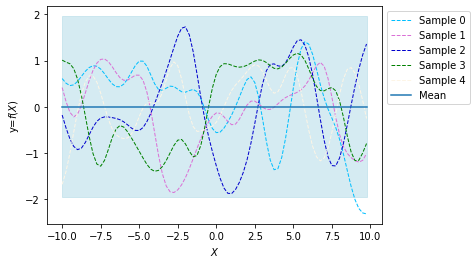

In [18]:
#Set sample number in a function
ns=50
#Set number of functions
nf=5

#Generate variables
X=np.arange(-10,10,0.25).reshape(-1,1)
GPplot_dist(X,n=nf)

### Gaussian process regression

Gaussian processes model distributions over functions and this can be used to model regression where the training data can be used to sample prior and using new points (e.g., test data) we can infer posteriors. Using maximum likelihood this can be transformed into predicted values.

Making predictions we can use posterior where given new data points $X_{2}$ (say, we get $n_{2}$) we want to predict $y_{2}=f(X_{2})$. We draw samples from the prior distribution defined by $y_{1}=f(X_{1})$ (our prior observations $n_{1}$). This can be defined as posterior of the form $p(y_{2} | y_{1},X_{1},X_{2})$.

Because of the joint marginal distribution for  $y_{1}$ and $y_{2}$ we can define the following:

$$

\left(\begin{array}{cc}
y_{1}\\
{y_{2}}
\end{array}\right)
\sim \N
\left(\begin{array}{cc}
\Sigma _{11}&\Sigma _{12}\\
\Sigma _{21}&\Sigma _{22}
\end{array}\right)
$$


$\mu 1=m(X_{1})$ ($n_{1}$ x 1)   and  $\mu 1=m(X_{2})$ ($n_{2}$ x 1) $\\$

$\Sigma 11=k(X_{1},X_{1})$ ($n_{1}$ x $n_{1}$)$\\$
$\Sigma 12=k(X_{1},X_{2})$ ($n_{1}$ x $n_{2}$)$\\$
$\Sigma 21=k(X_{2},X_{1})$ ($n_{2}$ x $n_{1}$)$\\$
$\Sigma 12=k(X_{2},X_{2})$ ($n_{2}$ x $n_{2}$)$\\$

Note $\Sigma 12$ and $\Sigma 21$ are equivalent because of the symmetry property for kernels and $\Sigma 11$ and $\Sigma 22$  are independent.

In [36]:
#Test that symetry indeed works
print(kernel(np.array([[0,1.2]]),np.array([[0.2,0.5]])))
print(kernel(np.array([[0.2,0.5]]),np.array([[0,1.2]])))

[[0.76720595]]
[[0.76720595]]


We can evaluate the conditional distribution:

$p(y_{2}|y_{1},X_{1},X_{2})=\N(\mu _{2|1}, \Sigma _{2|1})$ $\\$
$\mu _{2|1} =\mu _{2}+\Sigma _{21}\Sigma _{11}^{-1})(y_{1}-\mu _{1})$ $\\$
Since  $\mu _{1}=0$  we get  $\mu _{2|1} =\mu _{2}+\Sigma _{21}\Sigma _{11}^{-1}y_{1}$ $\\$
$\Sigma _{2|1} =\Sigma _{22}-\Sigma _{21}\Sigma _{11}^{-1}\Sigma _{12}$ $\\$


For computational purposes you can notice that $\Sigma _{11}=\Sigma _{11}^{T}$ which allows us to write the expressions:



$\mu _{2|1} = =\mu _{2}+(\Sigma _{11}^{-1}\Sigma _{12})^{T}y_{1}$ $\\$
$\Sigma _{2|1} =\Sigma _{22}-(\Sigma _{11}^{-1}\Sigma _{12})^{T}\Sigma _{12}$ $\\$

This allows us to use scipy.linalg.solve to get:

$a*x=b$ to  $x=a^{-1}b$ which is analogous to $\Sigma _{11}^{-1}\Sigma _{12}$


We are also going to incorporate noise into Gaussian process distribution analysis. The above examples assumed noiseless distributions and this can be used for modelling. However, many observations require noise modelling.

Noise modelling is achieved using the following identity $f(X_{1})=y_{1}+\epsilon$ where $\epsilon$ or noise is modelled after Gaussian noise distribution with variance $\sigma ^{2}$

We can add this to the covariance kernel of the initial observations:
$\Sigma _{11}=K(X_{1},X_{2})+\sigma ^{2}I$



In [134]:
def posterior(X2,X1,y1,l=1.0,sigma=1.0,noise=1e-10):
    """
        Function draws samples from the posterior and plots their distribution
        #Arguments
        X2, array(int/float), nxk values: new samples
        X1, array(int/float), mxk values: X_train data
        y1, array(int/float), mx1 values: y_trainlabel data
        l, float: kernel length/smoothness parameter, default value is 1.0
        sigma, float: kernel vertical variation parameter, default value is 1.0
        noise, float: kernel noise parameter,, default value is 1-e10
        
        #Returns
        Posterior probability mean and covariance matrix values for the sample data
        NOTE mean is always set to be zero. This can be changed if needed
    """
    #Get kernels including noise
    k_11=kernel(X1,X1,l,sigma)+((noise**2)*np.eye(len(X1))) #n1 noise addition
    k_12=kernel(X1,X2,l,sigma)
    k_22=kernel(X2,X2,l,sigma)

    #Alternative calculation method
    k11_12=k_12.T.dot(np.linalg.inv(k_11))#scipy.linalg.solve(k_11,k_12,assume_a='pos').T
    mu_sample=k11_12.dot(y1)
    sigma_sample=k_22-k11_12.dot(k_12)

    #Alternative calculation method
    #k_inv=np.linalg.inv(k_11)

    #mu_sample=np.dot(np.dot(k_12.T,k_inv),y_train)
    #sigma_sample=k_22-np.dot(np.dot(k_12.T,k_inv),k_12)
   

    return mu_sample,sigma_sample

In [115]:
#General plot to evaluate distributions 
def GPplot(X_sample,mu,cov,n=5):
    """
        Plots Gaussian distributions sampled for a sample set
        #Arguments
        mu, array(int/float), nx1 values: mean values
        cov, array(int/float), mxk values: covariance values
        X_sample, array(int/float), mxk values: sampled data
        n, int: sample set size; that is, the number of functions that will be sampled from the posterior distribution, default value is 5
        #Returns
        Plot for Gaussian distributions
        NOTE mean is always set to be zero. This can be changed if needed
    """

    y_pred=np.random.multivariate_normal(mu.ravel(),cov,n)


    #Plot samples

    fig,ax=plt.subplots(1,1)
    #set colors
    colors=mcolors.CSS4_COLORS
    colors=list(colors.values())

    random.shuffle(colors)
    if len(colors)<n:
        raise Exception("Too many samples, please redefine color library")

    uncertainty=np.sqrt(np.diag(cov))*1.96

    for i,sample in enumerate(y_pred):
              
        plt.plot(X_sample.ravel(),sample,lw=1,ls="--",color=colors[i],label="Sample "+str(i))
    
    plt.plot(X_sample.ravel(),mu.ravel(),color='red',label="Mean")
    plt.fill_between(X_sample.ravel(),mu.ravel()+uncertainty,mu.ravel(),color='lightblue',alpha=0.5)
    plt.xlabel("$X$")
    plt.ylabel("$Y$")
    plt.legend(loc="best", bbox_to_anchor=(1,1))
    plt.show()

In [86]:
#General plot to evaluate distributions 
def PriorPosterior_plot(X2,X1,y1,mu2,sigma2, func=None,func_name=None):
    """
        Plots prior and posterior distributions of data
        #Arguments
        mu2, array(int/float), nx1 values: mean values for mu2
        sigma, array(int/float), nxn values: standard deviation values
        X1, array(int/float), mxk values: initial observation values
        y1, array(int/float), mx1 values: initial observation values for f(X1)
        X2, array(int/float), mxk values: new data points X2
        func,  function obj: function that generated data, default value is None
        func_name,  function obj: function's name that generated data, default value is None
        
        #Returns
        Plot for prior and posterior distributions

    """


    #Plot samples

    fig,ax=plt.subplots(1,1)

    y2_actual=func(X2)
    y2_actual=y2_actual.reshape(-1,1)
    plt.scatter(X1.ravel(),y1,s=0.25,color='blue',label="Sample (X1,y1)")
    if func is not None:
        plt.plot(X2.ravel(),y2_actual,color='orange',ls='--',label="Function "+("" if func_name is None else func_name))
    plt.scatter(X2.ravel(),mu2.ravel(),color='red',s=0.25,label="$\mu 2|1$")

    plt.fill_between(X2.ravel(),mu2.ravel()+sigma2,mu2.ravel()-sigma2,color='lightblue',alpha=0.5,label="$2\sigma _{1|2}$")
    plt.xlabel("$X$")
    plt.ylabel("$Y$")
    plt.legend(loc="best", bbox_to_anchor=(1,1))
    plt.show()

    return

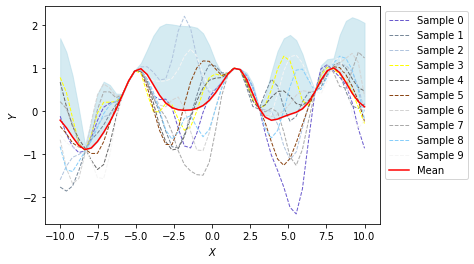

In [143]:
#Set parameters to test Gaussian process distribution
n1=10 #the number of available observations
n2=50 #new test points
ny=10 #number of functions to sample
domain=(-10,10) #set the domain

#Sample random observations (y1,X1)
#NOTE for reproducibility you may want to set seed

X1=np.random.uniform(domain[0],domain[1],size=(n1,1))
y1=np.sin(X1).reshape(-1,1)

#Sample X2 points
X2=np.linspace(domain[0],domain[1],n2).reshape(-1,1)

#Get means and covariance for observations X2
mu2,cov2=posterior(X2,X1,y1,l=1.0,sigma=1.0,noise=0) #Set noise to zero
sigma2=np.sqrt(np.diag(cov2))
#Assess value distributions
GPplot(X2,mu2,cov2,n=ny)

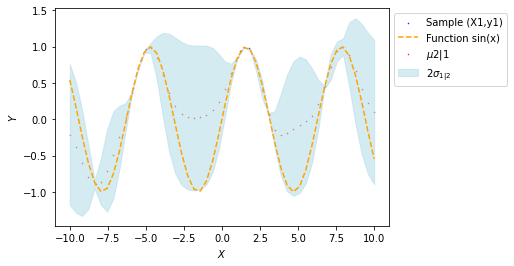

In [144]:
#Evaluate distributions for prior and posterior data
func=lambda x: np.sin(x)
PriorPosterior_plot(X2,X1,y1,mu2,sigma2,func,'sin(x)')

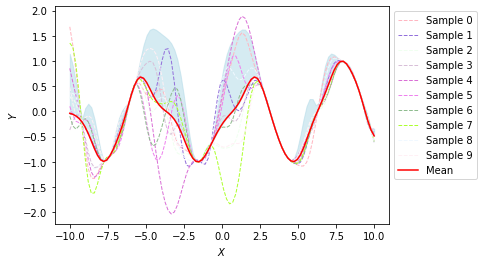

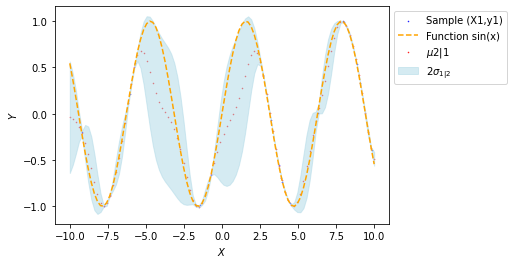

In [116]:
#You can observe how plots change based on the sampling data and l as sigma parameters

n1=20 #the number of available observations
n2=100 #new test points
ny=10 #number of functions to sample
domain=(-10,10) #set the domain

#Sample random observations (y1,X1)
#NOTE for reproducibility you may want to set seed

X1=np.random.uniform(domain[0],domain[1],size=(n1,1))
y1=np.sin(X1).reshape(-1,1)

#Sample X2 points
X2=np.linspace(domain[0],domain[1],n2).reshape(-1,1)

#Get means and covariance for observations X2
mu2,cov2=posterior(X2,X1,y1,l=0.75,sigma=0.75,noise=0) #Set noise to zero
sigma2=np.sqrt(np.diag(cov2))
#Assess value distributions
GPplot(X2,mu2,cov2,n=ny)
func=lambda x: np.sin(x)
PriorPosterior_plot(X2,X1,y1,mu2,sigma2,func,'sin(x)')

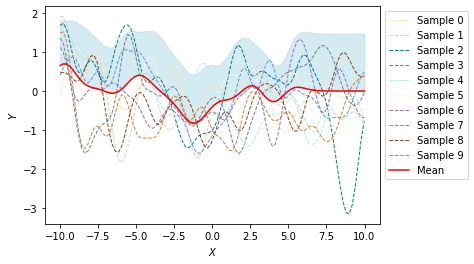

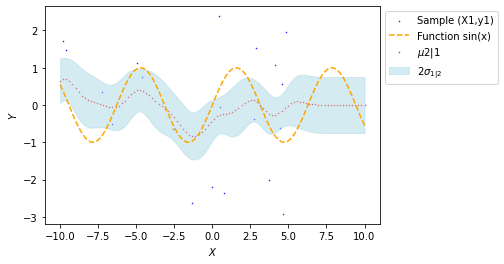

In [168]:
#You can observe how plots change based on the sampling data and l as sigma parameters
#NOTE this data is evaluated with noise
n1=20 #the number of available observations
n2=100 #new test points
ny=10 #number of functions to sample
domain=(-10,10) #set the domain
noise=1.2 #the standard deviation for noise
#Sample random observations (y1,X1)
#NOTE for reproducibility you may want to set seed

X1=np.random.uniform(domain[0],domain[1],size=(n1,1))
y1=np.sin(X1)+((noise**2)*np.random.randn(n1)).reshape(-1,1)

#Sample X2 points
X2=np.linspace(domain[0],domain[1],n2).reshape(-1,1)

#Get means and covariance for observations X2
mu2,cov2=posterior(X2,X1,y1,l=0.75,sigma=0.75,noise=noise) #Set noise to zero
sigma2=np.sqrt(np.diag(cov2))
#Assess value distributions
GPplot(X2,mu2,cov2,n=ny)
func=lambda x: np.sin(x)
PriorPosterior_plot(X2,X1,y1,mu2,sigma2,func,'sin(x)')

### Key observations

* Selecting a finite set from the Gaussianprocess distribution creates a multivariate Gaussian
* Gaussian process is a distribution over functions that can be defined by a mean and covariance.
* We make posterior predictions of a Gaussian process using the observed data that is weighed based on the sampled data.
